# Projet 5 : Segmentez des clients d'un site e-commerce

Notebook de simulation pour déterminer le rythme de maintenance du clustering.

*Olist* souhaite que vous fournissiez à ses équipes d'e-commerce une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de **comprendre les différents types d’utilisateurs** grâce à leur comportement et à leurs données personnelles.

Vous devrez **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une **proposition de contrat de maintenance** basée sur une analyse de la stabilité des segments au cours du temps.


# Summary
 - <a href="#C1">Import and settings</a>
      - <a href="#C1.1">Import required items</a>
      - <a href="#C1.2">Settings</a>
 - <a href="#C2">Functions</a>
 - <a href="#C3">Maintenance scenarios</a>
      - <a href="#C3.1">Data preparation and settings</a>
      - <a href="#C3.2">Proposal 1 : Prices, items number, review score and product categories</a>
      - <a href="#C3.3">Proposal 2 : Prices, items number, and review score</a>

# <a name="C1"> Import and settings
## <a name="C1.1"> Import required items

In [1]:
# Use code formatting tool
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Import required librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection
from mpl_toolkits import mplot3d

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn import (
    cluster,
    metrics,
    manifold,
    decomposition,
    ensemble,
)
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cut_tree

import datetime

<IPython.core.display.Javascript object>

In [3]:
# Import data files in DataFrames
data_final = pd.read_csv("data_final.csv", index_col=0)

<IPython.core.display.Javascript object>

## <a name="C1.2"> Settings

In [4]:
# Set the results display
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 100)
pd.options.display.float_format = "{:,.4f}".format

<IPython.core.display.Javascript object>

In [5]:
# General settings
random = 42

<IPython.core.display.Javascript object>

# <a name="C2"> Functions

In [6]:
# Function to create a 3D projection plot
def display_3D(X_trans, x, y, z):
    """
    This function allows to create a 3 dimension plot in order to display a data projection
    done using a feature reduction method (PCA, kPCA, TSNE, lle...).

    Parameters
    ----------
    X_trans : 3 dimensions (minimum) array
    x : int, X_trans column to be used for the x axis
    y : int, X_trans column to be used for the y axis
    z : int, X_trans column to be used for the z axis

    Return
    ------
    3D plot

    """
    fig = plt.figure(figsize=[7, 7])
    ax = plt.axes(projection="3d")

    ax.plot(
        X_trans[:, x],
        X_trans[:, y],
        X_trans[:, z],
        ".",
    )
    plt.show

<IPython.core.display.Javascript object>

In [7]:
# Function to create a 3D projection plot
def display_clusters_3D(X_trans, my_cluster, x, y, z):
    """
    This function allows to create a 3 dimension plot in order to display a data projection
    done using a feature reduction method (PCA, kPCA, TSNE, lle...).
    In case there is a clustering, display the values using colors accordingly.

    Parameters
    ----------
    X_trans : 3 dimensions (minimum) array
    my_cluster : 1 dimension array representing the cluster for each individual
    x : int, X_trans column to be used for the x axis
    y : int, X_trans column to be used for the y axis
    z : int, X_trans column to be used for the z axis

    Return
    ------
    3D plot

    """
    fig = plt.figure(figsize=[7, 7])
    ax = plt.axes(projection="3d")

    # Set the colors
    color = cm.brg(np.linspace(0, 1, np.max(my_cluster) - np.min(my_cluster) + 1))

    for i in range(np.min(my_cluster), np.max(my_cluster) + 1):
        ax.plot(
            X_trans[my_cluster == i][:, x],
            X_trans[my_cluster == i][:, y],
            X_trans[my_cluster == i][:, z],
            ".",
            color=color[i],
            label=i,
        )
        ax.text(
            X_trans[my_cluster == i][:, x][0],
            X_trans[my_cluster == i][:, y][0],
            X_trans[my_cluster == i][:, z][0],
            str(i),
            color="black",
            size=16,
        )
        plt.legend(bbox_to_anchor=(1.2, 0.5), loc="right")
        plt.show

<IPython.core.display.Javascript object>

In [8]:
# Function to plot a dendrogram in order to figure out how the relevant number of clusters
def plot_dendrogram(Z, names, p):
    """
    This function allows to create a dendrogram plot in order to figure out how the relevant number of clusters for the tested dataset.

    Parameters
    ----------
    Z : hierarchical clustering method to be used
    names : dataframe, data to be tested
    p : int, maximum number of clusters to display in the plot

    Return
    ------
    plot

    """
    plt.figure(figsize=(10, 7))
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("distance")
    dendrogram(
        Z,
        truncate_mode="lastp",  # show only the last p merged clusters
        p=p,  # show only the last p merged clusters
        show_leaf_counts=True,  # numbers in brackets are counts
        labels=names,
        orientation="top",
    )
    plt.show()

<IPython.core.display.Javascript object>

# <a name="C3"> Maintenance scenarios

In [9]:
# Explore data
print(len(data_final))
data_final.describe()

111047


,client_geolocation_lat,client_geolocation_lng,order_nb,delivery_delay_days,items_nb,last_order_days,order_freq,total_items_nb,product_description,product_photos_qty,price,freight_value,payment_installments,seller_geolocation_lat,seller_geolocation_lng,review_nb,review_score,review_comment_lenght,cat_culture & tech,cat_daylife,cat_fashion & gifts,cat_home & works,cat_other,payment_boleto,payment_credit_card,payment_debit_card,payment_voucher,voucher_share
count,"110,750.0000","110,750.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,044.0000","110,795.0000","110,795.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,047.0000","111,044.0000"
mean,-21.2357,-46.2009,1.0839,12.6992,1.3963,364.1316,0.2061,1.5057,836.6430,2.2097,120.7787,20.0252,3.0241,-22.7973,-47.2452,0.9975,4.0026,30.9369,0.2732,0.0959,0.2319,0.3948,0.0043,0.2031,0.7599,0.0149,0.0221,0.0221
std,5.5768,4.0449,0.3988,9.6582,1.1226,153.1508,6.7346,1.3323,653.1295,1.7214,183.4197,15.8406,2.8081,2.7044,2.3457,0.1198,1.4270,50.7931,0.4456,0.2944,0.4220,0.4888,0.0656,0.4023,0.4271,0.1213,0.1469,0.1450
min,-36.6054,-72.6667,1.0000,1.0000,1.0000,120.0000,0.0000,1.0000,35.0000,1.0000,0.8500,0.0000,0.0000,-36.6054,-67.8097,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,-23.5908,-48.1104,1.0000,7.0000,1.0000,240.0000,0.0000,1.0000,400.0000,1.0000,39.9000,13.0800,1.0000,-23.6120,-48.8315,1.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
50%,-22.9309,-46.6331,1.0000,10.0000,1.0000,344.0000,0.0000,1.0000,650.0000,1.0000,74.9900,16.3000,2.0000,-23.4207,-46.7552,1.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
75%,-20.1894,-43.6329,1.0000,16.0000,1.0000,473.0000,0.0000,2.0000,"1,041.0000",3.0000,134.9000,21.1800,4.0000,-21.7665,-46.5181,1.0000,5.0000,47.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
max,42.1840,-8.5779,17.0000,210.0000,21.0000,848.0000,444.0000,24.0000,"4,047.0000",20.0000,"6,735.0000",409.6800,24.0000,-2.5461,-34.8479,3.0000,5.0000,227.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


<IPython.core.display.Javascript object>

In [10]:
data_final.columns

Index(['customer_unique_id', 'client_geolocation_lat',
       'client_geolocation_lng', 'client_geolocation_city',
       'client_geolocation_state', 'order_nb', 'order_id',
       'delivery_delay_days', 'items_nb', 'last_order_days', 'order_freq',
       'order_purchase_timestamp', 'total_items_nb', 'product_id',
       'product_description', 'product_photos_qty', 'price', 'freight_value',
       'payment_installments', 'seller_id', 'seller_geolocation_lat',
       'seller_geolocation_lng', 'seller_geolocation_city',
       'seller_geolocation_state', 'review_nb', 'review_score',
       'review_comment_lenght', 'cat_culture & tech', 'cat_daylife',
       'cat_fashion & gifts', 'cat_home & works', 'cat_other',
       'payment_boleto', 'payment_credit_card', 'payment_debit_card',
       'payment_voucher', 'voucher_share'],
      dtype='object')

<IPython.core.display.Javascript object>

## <a name="C3.1"> Data preparation and settings

In [11]:
# in order to consider data by unique customer, we need to calculate mean values by order, and by product.

# List the features by order in order to calculate mean values
order_features = [
    "customer_unique_id",
    "order_id",
    "order_nb",
    "order_freq",
    "items_nb",
    "review_score",
    "review_comment_lenght",
    "voucher_share",
    "last_order_days",
]

# List the features by product in order to calculate mean values
product_features = [
    "customer_unique_id",
    "total_items_nb",
    "price",
    "freight_value",
    "product_photos_qty",
    "cat_culture & tech",
    "cat_daylife",
    "cat_fashion & gifts",
    "cat_home & works",
]

# Minimum Adjusted Rand Index value to consider the clustering is good
ARI_limit = 0.70

<IPython.core.display.Javascript object>

In [12]:
# Let's look at the distribution of the orders in time
data_final["year"] = pd.to_datetime(data_final["order_purchase_timestamp"]).dt.year
data_final["month"] = pd.to_datetime(data_final["order_purchase_timestamp"]).dt.month
data_final.pivot_table(
    index=["year", "month"], values=["order_id"], aggfunc="count"
).transpose()

year     2016         2017                                                  \
month      9    10 12   1     2     3     4     5     6     7     8     9    
order_id    6  361  1  942  1893  2937  2613  4040  3520  4458  4833  4757   

year                        2018                                               
month       10    11    12    1     2     3     4     5     6     7     8  9   
order_id  5249  8543  6162  8000  7552  8082  7899  7882  7055  7045  7216  1

<IPython.core.display.Javascript object>

In [13]:
# Let's start our analysis from January 2017 because the data is less consistant in 2016.
date_min = pd.to_datetime("2017-01-01")
date_max = data_final["order_purchase_timestamp"].max()
total_week = int(
    pd.to_timedelta(pd.to_datetime(date_max) - pd.to_datetime(date_min))
    / pd.Timedelta(7, "d")
)

print("Minimum order date :", date_min)
print("Maximum order date :", date_max)
print("Total number of weeks :", total_week)

# share of the data we'll use in the simulation
week_nb = int(total_week * 0.75)
print("Numnber of weeks for the maintenance simulation :", week_nb)

period_0 = datetime.timedelta(days=7 * (total_week - week_nb))
print("Number of days for initial clustering :", period_0)

date_0 = pd.to_datetime(date_min) + period_0
print("Date max for initial period :", date_0)

Minimum order date : 2017-01-01 00:00:00
Maximum order date : 2018-09-03 09:06:57
Total number of weeks : 87
Numnber of weeks for the maintenance simulation : 65
Number of days for initial clustering : 154 days, 0:00:00
Date max for initial period : 2017-06-04 00:00:00


<IPython.core.display.Javascript object>

## <a name="C3.2"> Proposal 1 : Prices, items number, review score and product categories

In [14]:
# list the columns that needs to be scaled
col_std = [
    "price",
    "total_items_nb",
    "review_score",
]

# and the columns that we'll keep as they are
col_other = [
    "cat_culture & tech",
    "cat_daylife",
    "cat_fashion & gifts",
    "cat_home & works",
]

<IPython.core.display.Javascript object>

In [15]:
# Set up the scaler
scale = ColumnTransformer(
    transformers=[
        ("std", StandardScaler(), col_std),
        ("no_std", "passthrough", col_other),
    ]
)

# Build the initial set of data
data_0 = data_final[pd.to_datetime(data_final["order_purchase_timestamp"]) <= date_0]

data_0_orders = (
    data_0[order_features]
    .drop_duplicates(subset="order_id")
    .pivot_table(index=["customer_unique_id"], aggfunc="mean")
    .reset_index()
)
data_0_products = (
    data_0[product_features]
    .pivot_table(index=["customer_unique_id"], aggfunc="mean")
    .reset_index()
)
data_0_pivot = pd.merge(
    data_0_orders, data_0_products, on="customer_unique_id", how="left"
)
data_0_pivot = data_0_pivot.dropna()

data_0 = data_0_pivot[col_std + col_other]

print(len(data_0))

# Fit the scaler on data_0
scaler = scale.fit(data_0)
# Scale the data_0 data
X_0 = scaler.transform(data_0)

11329


<IPython.core.display.Javascript object>

Let's now consider the best number of clusters using the initial data only.

In [16]:
# Method to test different clustering solutions and assess the stability of each one of them
# Clustering method : Kmeans
# Number of clusters to be tested
params = [3, 4, 5, 6, 7, 8]
# Number of data samples to be used to cross test the clusters
n = 4
# Sample size
k = int(len(X_0) / n)

# Create a DataFrame to gather results
summary_kmeans = pd.DataFrame(
    columns=["clusters", "k", "silhouette", "calinski_harabasz", "davies_bouldin"]
)

# Test each cluster number
for par in params:
    kmeans_cv = cluster.KMeans(n_clusters=par, n_init=15, random_state=random)
    a = X_0
    # Test different data sample
    for i in range(n):
        if i != n:
            l = np.arange(len(a))
            rand = np.random.choice(l, size=k, replace=False)
            sub = a[rand, :]
            a = a[~rand, :]
        else:
            sub = a

        # fit the clustering and get their labels
        clustering = kmeans_cv.fit(sub).labels_

        # Calculate metrics to assess clustering quality
        sil = metrics.silhouette_score(sub, clustering)
        cal = metrics.calinski_harabasz_score(sub, clustering)
        dav = metrics.davies_bouldin_score(sub, clustering)

        # set the row where to add the data in the DataFrame
        r = len(summary_kmeans) + 1

        # Add the data in the DataFrame
        summary_kmeans.loc[r] = [par, i, sil, cal, dav]

        i += 1

# Display the table
summary_kmeans

,clusters,k,silhouette,calinski_harabasz,davies_bouldin
1,3.0000,0.0000,0.3845,978.8372,1.0372
2,3.0000,1.0000,0.3757,951.7450,1.0615
3,3.0000,2.0000,0.3757,951.7450,1.0615
4,3.0000,3.0000,0.3757,951.7450,1.0615
5,4.0000,0.0000,0.3931,"1,064.2105",0.9074
6,4.0000,1.0000,0.3998,958.2850,0.9398
7,4.0000,2.0000,0.3990,937.6618,1.0173
8,4.0000,3.0000,0.3910,965.3687,0.8681
9,5.0000,0.0000,0.3137,899.9122,1.0326
10,5.0000,1.0000,0.3007,935.7187,1.0765


<IPython.core.display.Javascript object>

In [17]:
# Display the mean values of the metrics for each cluster number
kmeans_pivot = summary_kmeans.pivot_table(
    values=["silhouette", "calinski_harabasz", "davies_bouldin"],
    index=["clusters"],
    aggfunc="mean",
)

# Set the best cluster number according to the best metrics
clusters_nb = int(
    round(
        (
            kmeans_pivot["silhouette"].idxmax()
            * 2  # more importance is given to the silhouette score
            + kmeans_pivot["davies_bouldin"].idxmin() / 2
            + kmeans_pivot["calinski_harabasz"].idxmax() / 2
        )
        / 3,
        0,
    )
)
print(clusters_nb)

kmeans_pivot

8


,calinski_harabasz,davies_bouldin,silhouette
clusters,,,
3.0000,958.5180,1.0554,0.3779
4.0000,981.3815,0.9331,0.3957
5.0000,926.7671,1.0655,0.3039
6.0000,939.8348,0.9847,0.3930
7.0000,981.1010,0.9467,0.3781
8.0000,"1,106.6343",0.9000,0.4302


<IPython.core.display.Javascript object>

In [18]:
# Fit the clustering using the most relevant number of clusters
kmeans_maint = cluster.KMeans(n_clusters=clusters_nb, n_init=15, random_state=random)
cluster_0 = kmeans_maint.fit(X_0)

print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X_0, cluster_0.predict(X_0))
)

Silhouette Coefficient: 0.427


<IPython.core.display.Javascript object>

In [19]:
# Create the Dataframe to gather the simulation results
maintenance = pd.DataFrame(columns=["weeks", "date", "customer_nb", "ARI"])

# for each considered week, build a new set of data
for i in range(week_nb + 1):
    date_maint = date_0 + datetime.timedelta(days=7 * i)

    data_maint = data_final[
        pd.to_datetime(data_final["order_purchase_timestamp"]) <= date_maint
    ]
    data_maint_orders = (
        data_maint[order_features]
        .drop_duplicates(subset="order_id")
        .pivot_table(index=["customer_unique_id"], aggfunc="mean")
        .reset_index()
    )
    data_maint_products = (
        data_maint[product_features]
        .pivot_table(index=["customer_unique_id"], aggfunc="mean")
        .reset_index()
    )
    data_maint_pivot = pd.merge(
        data_maint_orders, data_maint_products, on="customer_unique_id", how="left"
    )
    data_maint_pivot = data_maint_pivot.dropna()

    data_maint = data_maint_pivot[col_std + col_other]

    # Scale the data using the scaler fitted on data_0
    X_maint_0 = scaler.transform(data_maint)
    # and scale it on the data itself for comparison
    X_maint_std = scale.fit_transform(data_maint)

    # create clusters using the clustering method for data_0
    labels_0 = cluster_0.predict(X_maint_0)
    # create clusters using the current data
    labels_maint = kmeans_maint.fit_predict(X_maint_std)

    # Calculate ARI
    ARI = metrics.adjusted_rand_score(labels_maint, labels_0)

    # Store the ARI in the table
    maintenance.loc[i] = [i, date_maint, len(X_maint_std), ARI]

maintenance

,weeks,date,customer_nb,ARI
0,0,2017-06-04,11329,1.0000
1,1,2017-06-11,12108,0.8027
2,2,2017-06-18,12839,0.9987
3,3,2017-06-25,13457,0.8700
4,4,2017-07-02,14150,0.8699
5,5,2017-07-09,14953,0.8112
6,6,2017-07-16,15844,0.8137
7,7,2017-07-23,16757,0.8146
8,8,2017-07-30,17615,0.8152
9,9,2017-08-06,18560,0.8112


<IPython.core.display.Javascript object>

52


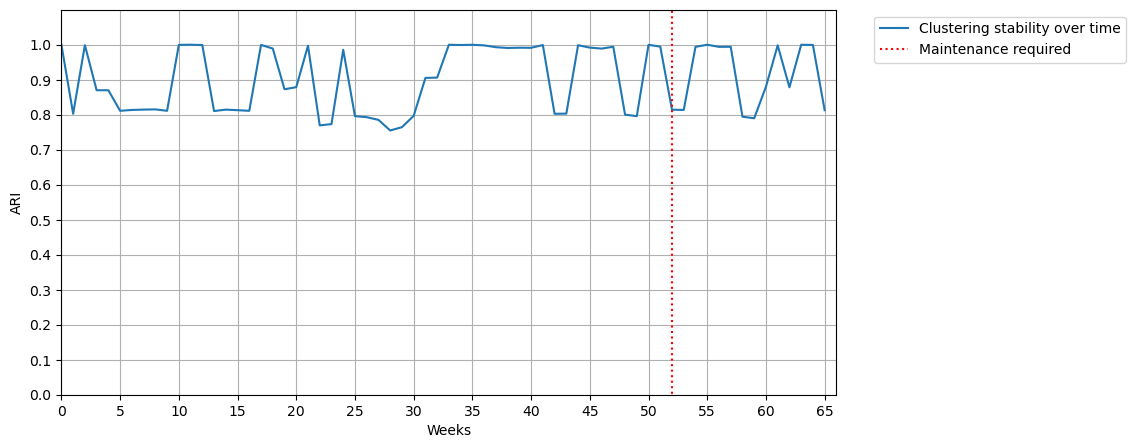

<IPython.core.display.Javascript object>

In [20]:
# Set the boundaries
ari_min = maintenance["ARI"].min()
ari_max = maintenance["ARI"].max()
week_max = maintenance["weeks"].max()

# Figure out when the ARI limit is breached
i = 0
while maintenance.loc[i, "ARI"] > ARI_limit:
    i += 1
    if i == len(maintenance):
        break
    limit = 52  # Let's consider that annual maintenance is the minimum
else:
    limit = maintenance.loc[i, "weeks"]
print(limit)

# Display the ARI evolution and the limit in a plot
fig = plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.plot(
    maintenance["weeks"], maintenance["ARI"], label="Clustering stability over time"
)

plt.grid(visible=True, which="both", axis="both")

ax.plot(
    [limit, limit],
    [maintenance["ARI"].min() - 5, maintenance["ARI"].max() + 5],
    color="#FF0000",
    linestyle="dotted",
    label="Maintenance required",
)

plt.axis(
    [
        0,
        week_max + 1,
        0,
        1.1,
    ]
)

plt.xlabel("Weeks")
plt.ylabel("ARI")

plt.xticks(np.arange(0, week_max + 1, 5))
plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

In [21]:
ari_min

0.7550117417087006

<IPython.core.display.Javascript object>

## <a name="C3.3"> Proposal 2 : Prices, items number, and review score

In [22]:
# Set up the scaler
scale = ColumnTransformer(
    transformers=[
        ("std", StandardScaler(), col_std),  # don't consider the categories
    ]
)

# Build the initial set of data
data_0 = data_final[pd.to_datetime(data_final["order_purchase_timestamp"]) <= date_0]

data_0_orders = (
    data_0[order_features]
    .drop_duplicates(subset="order_id")
    .pivot_table(index=["customer_unique_id"], aggfunc="mean")
    .reset_index()
)
data_0_products = (
    data_0[product_features]
    .pivot_table(index=["customer_unique_id"], aggfunc="mean")
    .reset_index()
)
data_0_pivot = pd.merge(
    data_0_orders, data_0_products, on="customer_unique_id", how="left"
)
data_0_pivot = data_0_pivot.dropna()

data_0 = data_0_pivot[col_std]

print(len(data_0))

# Fit the scaler on data_0
scaler = scale.fit(data_0)
# Scale the data_0 data
X_0 = scaler.transform(data_0)

11329


<IPython.core.display.Javascript object>

In [23]:
# Method to test different clustering solutions and assess the stability of each one of them
# Clustering method : Kmeans
# Number of clusters to be tested
params = [3, 4, 5, 6, 7, 8]
# Number of data samples to be used to cross test the clusters
n = 4
# Sample size
k = int(len(X_0) / n)

# Create a DataFrame to gather results
summary_kmeans = pd.DataFrame(
    columns=["clusters", "k", "silhouette", "calinski_harabasz", "davies_bouldin"]
)

# Test each cluster number
for par in params:
    kmeans_cv = cluster.KMeans(n_clusters=par, n_init=15, random_state=random)
    a = X_0
    # Test different data sample
    for i in range(n):
        if i != n:
            l = np.arange(len(a))
            rand = np.random.choice(l, size=k, replace=False)
            sub = a[rand, :]
            a = a[~rand, :]
        else:
            sub = a

        # fit the clustering and get their labels
        clustering = kmeans_cv.fit(sub).labels_

        # Calculate metrics to assess clustering quality
        sil = metrics.silhouette_score(sub, clustering)
        cal = metrics.calinski_harabasz_score(sub, clustering)
        dav = metrics.davies_bouldin_score(sub, clustering)

        # set the row where to add the data in the DataFrame
        r = len(summary_kmeans) + 1

        # Add the data in the DataFrame
        summary_kmeans.loc[r] = [par, i, sil, cal, dav]

        i += 1

# Display the table
summary_kmeans

,clusters,k,silhouette,calinski_harabasz,davies_bouldin
1,3.0000,0.0000,0.5459,"1,293.2980",0.7746
2,3.0000,1.0000,0.5591,"1,563.4741",0.7589
3,3.0000,2.0000,0.5591,"1,563.4741",0.7589
4,3.0000,3.0000,0.5591,"1,563.4741",0.7589
5,4.0000,0.0000,0.5534,"1,705.6078",0.7029
6,4.0000,1.0000,0.5661,"1,625.1309",0.7030
7,4.0000,2.0000,0.5661,"1,625.1309",0.7030
8,4.0000,3.0000,0.5549,"1,558.6214",0.6928
9,5.0000,0.0000,0.5835,"1,868.3633",0.6621
10,5.0000,1.0000,0.5755,"1,640.5007",0.6413


<IPython.core.display.Javascript object>

In [24]:
# Display the mean values of the metrics for each cluster number
kmeans_pivot = summary_kmeans.pivot_table(
    values=["silhouette", "calinski_harabasz", "davies_bouldin"],
    index=["clusters"],
    aggfunc="mean",
)

# Set the best cluster number according to the best metrics
clusters_nb = int(
    round(
        (
            kmeans_pivot["silhouette"].idxmax()
            * 2  # more importance is given to the silhouette score
            + kmeans_pivot["davies_bouldin"].idxmin() / 2
            + kmeans_pivot["calinski_harabasz"].idxmax() / 2
        )
        / 3,
        0,
    )
)
print(clusters_nb)

kmeans_pivot

6


,calinski_harabasz,davies_bouldin,silhouette
clusters,,,
3.0000,"1,495.9301",0.7629,0.5558
4.0000,"1,628.6227",0.7004,0.5601
5.0000,"1,696.5822",0.6544,0.5778
6.0000,"1,715.9477",0.6867,0.5848
7.0000,"2,113.1441",0.6668,0.5557
8.0000,"2,071.4471",0.6593,0.5623


<IPython.core.display.Javascript object>

In [25]:
# Fit the clustering using the most relevant number of clusters
kmeans_maint = cluster.KMeans(n_clusters=clusters_nb, n_init=15, random_state=random)
cluster_0 = kmeans_maint.fit(X_0)

print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X_0, cluster_0.predict(X_0))
)

Silhouette Coefficient: 0.599


<IPython.core.display.Javascript object>

In [26]:
# Create the Dataframe to gather the simulation results
maintenance = pd.DataFrame(columns=["weeks", "date", "customer_nb", "ARI"])

# for each considered week, build a new set of data
for i in range(week_nb + 1):
    date_maint = date_0 + datetime.timedelta(days=7 * i)

    data_maint = data_final[
        pd.to_datetime(data_final["order_purchase_timestamp"]) <= date_maint
    ]
    data_maint_orders = (
        data_maint[order_features]
        .drop_duplicates(subset="order_id")
        .pivot_table(index=["customer_unique_id"], aggfunc="mean")
        .reset_index()
    )
    data_maint_products = (
        data_maint[product_features]
        .pivot_table(index=["customer_unique_id"], aggfunc="mean")
        .reset_index()
    )
    data_maint_pivot = pd.merge(
        data_maint_orders, data_maint_products, on="customer_unique_id", how="left"
    )
    data_maint_pivot = data_maint_pivot.dropna()

    data_maint = data_maint_pivot[col_std]

    # Scale the data using the scaler fitted on data_0
    X_maint_0 = scaler.transform(data_maint)
    # and scale it on the data itself for comparison
    X_maint_std = scale.fit_transform(data_maint)

    # create clusters using the clustering method for data_0
    labels_0 = cluster_0.predict(X_maint_0)
    # create clusters using the current data
    labels_maint = kmeans_maint.fit_predict(X_maint_std)

    # Calculate ARI
    ARI = metrics.adjusted_rand_score(labels_maint, labels_0)

    # Store the ARI in the table
    maintenance.loc[i] = [i, date_maint, len(X_maint_std), ARI]

maintenance

,weeks,date,customer_nb,ARI
0,0,2017-06-04,11329,1.0000
1,1,2017-06-11,12108,0.9792
2,2,2017-06-18,12839,0.9995
3,3,2017-06-25,13457,0.9963
4,4,2017-07-02,14150,0.9967
5,5,2017-07-09,14953,0.7734
6,6,2017-07-16,15844,0.7703
7,7,2017-07-23,16757,0.9999
8,8,2017-07-30,17615,0.9972
9,9,2017-08-06,18560,0.9999


<IPython.core.display.Javascript object>

10


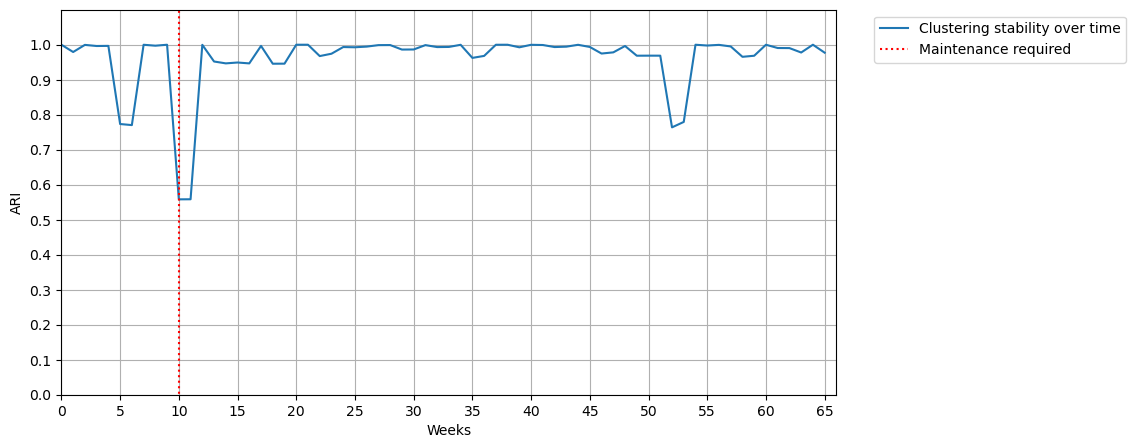

<IPython.core.display.Javascript object>

In [27]:
# Set the boundaries
ari_min = maintenance["ARI"].min()
ari_max = maintenance["ARI"].max()
week_max = maintenance["weeks"].max()

# Figure out when the ARI limit is breached
i = 0
while maintenance.loc[i, "ARI"] > ARI_limit:
    i += 1
    if i == len(maintenance):
        break
    limit = 52  # Let's consider that annual maintenance is the minimum
else:
    limit = maintenance.loc[i, "weeks"]
print(limit)

# Display the ARI evolution and the limit in a plot
fig = plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.plot(
    maintenance["weeks"], maintenance["ARI"], label="Clustering stability over time"
)

plt.grid(visible=True, which="both", axis="both")

ax.plot(
    [limit, limit],
    [maintenance["ARI"].min() - 5, maintenance["ARI"].max() + 5],
    color="#FF0000",
    linestyle="dotted",
    label="Maintenance required",
)

plt.axis(
    [
        0,
        week_max + 1,
        0,
        1.1,
    ]
)

plt.xlabel("Weeks")
plt.ylabel("ARI")

plt.xticks(np.arange(0, week_max + 1, 5))
plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

In [28]:
ari_min

0.5582091353386458

<IPython.core.display.Javascript object>